# Activity 1a - 2D Image Transformations

Your name: Dylan Rodrigues

Your ID number: 24121479

In this activity, we are going to look into 2D image transformations. We are going to look into the basics of image warping, including back-mapping to fill vacant pixels. We we also get the first taste of homogeneous coordinates and homogeneous transformations.

But first, we will start with the basics.

A couple of general notes.
 * First, I will often give you some template code to start working from in the cells. I will denote areas where you should insert your own code with a "your code here" comment.  
 * Occasionally, I will ask questions that you must also answer. These will be highlighted in a different colour.
 * In the first task of the module, some code is provided below, to help you on your way. However, as we progress through the module, I will give you less and less code to start.
 * I also spell out the steps in quite some detail here, however, as we progress, I will expect to not have to give such detail.
 * You must not use external libraries other than numpy for calculations and pyplot for displaying the images. We use OpenCV just to read the images - but this must not be used elsewhere. All the libraries are imported in the first cell.

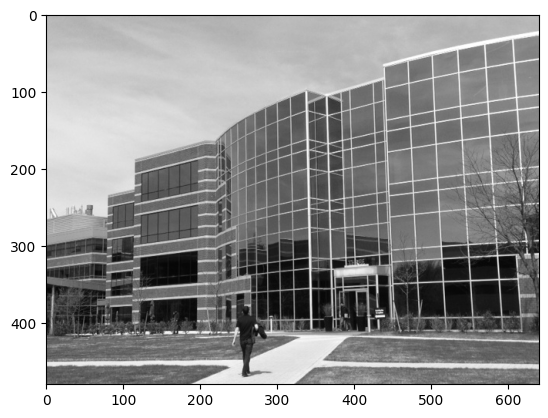

In [3]:
###################
# code given
import cv2                      # we use this mainly to read the files
import numpy as np              # the everpresent numpy
import matplotlib.pyplot as plt # does what it says on the tin - plotting

# Read in the image. We don't want to mess with colour, so we convert to grayscale.
# Let's also have a look at the image
img = cv2.imread('building1.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap='gray')

## A simple scaling

We want to implement a simple scaling, as is described in Video Lecture 1.2

The transform for scaling is given by the matrix:
$$
\textbf{T} = \begin{bmatrix}
a & 0 \\
0 & b
\end{bmatrix}
$$
and thus, to transform the points in the image, we use
$$
\begin{bmatrix} x' \\ y' \end{bmatrix} =
\begin{bmatrix}
a & 0 \\
0 & b
\end{bmatrix}  
\begin{bmatrix} x \\ y \end{bmatrix}
$$
where $(x, y)$ is the point in the original image, and $(x', y')$ is the transformed point.


<font color='blue'>

#### Task:
    
In Python code, implement the scaling defined by the equations above. For each pixel in the original image, we will apply the transform, and put the pixel value at the resulting position in the output image.
    
1. Create the transformation matrix
1. Create an empty (black) image where the new image will be stored (hint [`np.zeros()`](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html))
1. Iterate over all the pixels in the image (e.g., as a nested pair of for loops)
1. Apply the transformation to each pixel location (i.e., to the vector $(x, y)$ representing the pixel location). Get the result $(x', y')$ vector
1. Check that the resulting location $(x', y')$ is within the bounds of the image. You will get an error if you try to write outside of the image boundary.
1. Copy the pixel value from the input image location $(x, y)$ to the (valid) output image location $(x', y')$ (interpolated).
1. Display the resulting image ([`plt.imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html), as above)

    
Some hints:
* Images are stored in grids, and the index (coordinate $(x, y)$) of each grid is an integer value. However, after you transform the integer coordinate using $\textbf{T}$, there is no guarantee that the resulting coordinates $(x', y')$ will be integer values.
* What do we do? This requires [**interpolation**](https://www.cambridgeincolour.com/tutorials/image-interpolation.htm), of which two popular methods are _bilinear_ and _bicubic_. However, for this task, we will just round our values to the nearest integer (which is, in fact, called _nearest neighbour_ interpolation).
* To do this, once you have transformed a point, I suggest to round to the nearest integer using [`np.rint()`](https://numpy.org/doc/stable/reference/generated/numpy.rint.html) and then cast to an `int` type using [`.astype(int)`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.astype.html)
    
</font>

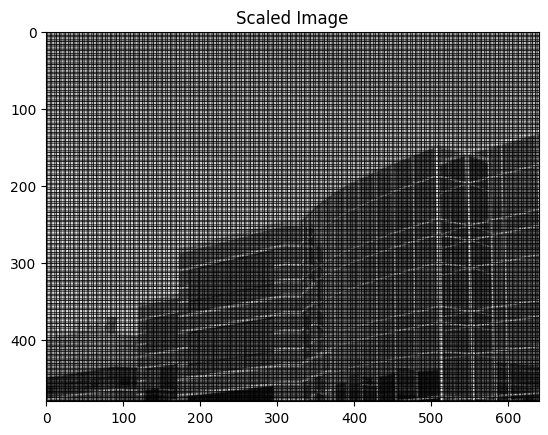

In [4]:
# Create a new empty image of the size of the original
img_new = np.zeros(img.shape)

# Create the transform matrix
T = np.array([[1.5, 0], [0, 1.5]])  # Your code here: Create the appropriate matrix
# T2 = np.array([...])


for y in range(img.shape[0]):  # iterate each row in the image
    for x in range(img.shape[1]):  # iterate each column
        # Your code here

        pt = np.array([x, y])
        pt_new = T @ pt
        x_new, y_new = np.rint(pt_new).astype(int)  # Round to nearest integer

        # check that the resulting point is within the image bounds
        if 0 <= x_new < img.shape[1] and 0 <= y_new < img.shape[0]: # add the code to check this
            img_new[y_new][x_new] = img[y][x]

# Display the new image
plt.imshow(img_new, cmap='gray')
plt.title('Scaled Image')
plt.show()

<font color='blue'>

###### Question: Some of the image has disappeared. Why? [Hint](https://blogs.mathworks.com/steve/2006/04/28/spatial-transforms-forward-mapping/)

Your answer here (double click to enter text)

The image has disappeared in some areas because of forward mapping, where pixels from the original image are mapped to new locations in the output image. Since scaling stretches the image, some output pixels may not receive a corresponding value, creating gaps or missing regions. Additionally, multiple original pixels might map to the same new location, causing loss of detail. This happens because forward mapping does not guarantee that every pixel in the output image gets assigned a value, leading to empty spaces.

<font color='blue'>

###### Question: Make sure your matrix contains scaling factors greater than 1 (i.e., causing an upscaling). Why are there black pixels?

Your answer here (double click to enter text)

The black pixels appear because of aliasing and gaps caused by forward mapping during upscaling. When scaling factors are greater than 1, the image is stretched, meaning some pixels in the output image do not get assigned a value from the original image. Since we are rounding transformed coordinates (using nearest-neighbor interpolation), some output pixels remain unfilled, leading to black pixels (default zero values in the np.zeros array).

## Back-mapping the pixels

In the last task, we ended up with black pixels (vacant pixels) in the resulting image. Now we will address this using the method of back mapping, also call [inverse mapping](https://blogs.mathworks.com/steve/2006/05/05/spatial-transformations-inverse-mapping/).

Let's look at forward mapping first. Consider each input image pixel in turn. For each input image pixel:

Forward mapping:
1. Determine its location in input space, $(x, y)$.
1. Map that location to output space using $(x',y')^\top = \textbf{T}(x,y)^\top$.
1. Figure out which output pixel contains the location $(x',y')$. I.e., convert to integer values.
1. Copy the input pixel value to that output pixel.

This diagram illustrates the procedure:
![image-3.png](attachment:image-3.png)


Forward mapping has two main disadvantages as a computational procedure: gaps and overlaps. Depending on specific spatial transform function, you may have some output pixels that did not receive any input image pixels; these are the gaps. You may also have some output pixels that received more than one input image pixel; these are the overlaps. In both cases, it is challenging to figure out a reasonable way to set those output pixels.

Because of the disadvantages of the forward mapping method, most of the practical implementations use a different technique, called back/inverse mapping.

Here's how it works:

Locate your output image pixel grid somewhere in output space. Then for each output pixel on the grid:

1. Apply the **inverse** spatial transformation to determine the corresponding location in input space: $(x,y)^\top = \textbf{T}^{-1}(x',y')^\top$.
1. Using the input image pixels nearest to $(x,y)$, *interpolate* to get an approximate value for the input image at $(x,y)$.
1. Use that value for the output pixel.

This diagram illustrates the procedure:
![image-2.png](attachment:image-2.png)

This method completely avoids problems with gaps and overlaps. You just have to decide which interpolation method to you (below, as above, we use the simplest nearest neighbour interpolation), and you also have to establish a rule for what value to use when $(x,y)$ isn't within the input image pixel grid.


<font color='blue'>

#### Task:
    
In Python code, implement the scaling using back mapping. For each pixel in the output image, we will apply the inverse transform, and copy the pixel value to the resulting position in the output image.
    
1. Create the transformation matrix
1. Invert the transformation ([`np.linalg.inv()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html))
1. Create an empty (black) image where the new image will be stored (hint [`np.zeros()`](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html))
1. Iterate over all the pixels in the **output** image (e.g., as a nested pair of for loops)
1. Apply the inverse transformation to each output pixel location (i.e., to the vector $(x', y')$ representing the output pixel location). Get the result $(x, y)$ vector representing the input pixel location
1. Check that the resulting location $(x, y)$ is within the bounds of the input image. You will get an error if you try to read outside of the image boundary.
1. Copy the (valid) pixel value from the input image location $(x, y)$ (interpolated) to the output image location $(x', y')$.
1. Display the resulting image ([`plt.imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html), as above)

As above, use nearest neighbour interpolation.
    
</font>

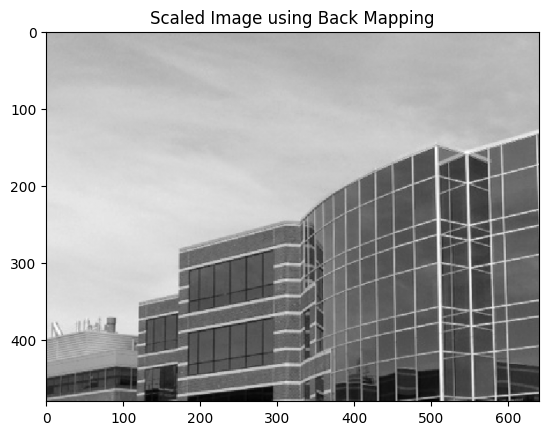

In [ ]:
# Create a new empty image of the size of the original
img_new = np.zeros(img.shape)

# Create the transform matrix
T = np.array([[1.5, 0], [0, 1.5]])  # Create the appropriate matrix

T_inv = np.linalg.inv(T)         # Invert the transform

for y_new in range(img.shape[0]):  # iterate each row in the output image
    for x_new in range(img.shape[1]):  # iterate each column

        # Apply inverse transformation to get corresponding input pixel
        pt_new = np.array([x_new, y_new])
        pt = T_inv @ pt_new
        x, y = np.rint(pt).astype(int)  # Nearest neighbor interpolation

        # check that the resulting point is within the input image bounds
        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]: # add the code to check this
            img_new[y_new][x_new] = img[y][x]

# Display the new image
plt.imshow(img_new, cmap='gray')
plt.title('Scaled Image using Back Mapping')
plt.show()

<font color='blue'>

###### Question: Why does this fill the gaps?

Your answer here (double click to enter text)

This method fills the gaps because it uses inverse mapping (back mapping) instead of forward mapping. Instead of mapping input pixels to output space (which can create gaps due to rounding and irregular spacing), we iterate over each output pixel and determine its corresponding location in the original image using the inverse transformation. By sampling from the original image and using nearest-neighbor interpolation, we ensure that every output pixel receives a valid intensity value, eliminating gaps and preserving image structure.

<font color='blue'>

###### Question: We use the inverse of the scaling matrix above. To estimate this, we use the Numpy function. But how would we calculate it directly, for the scaling matrix? Or, to put it another way, what does the inverse of the scaling matrix look like?

Your answer here (double click to enter text)

The inverse of a scaling matrix can be computed by taking the reciprocal of each of its diagonal elements. If the scaling matrix has scaling factors Sx, Sy, and Sz, then the inverse would simply have scaling factors of 1/Sx, 1/Sy, and 1/Sz along the respective axes. This is because the scaling matrix is diagonal, and inverting a diagonal matrix involves inverting the individual diagonal values.

## More transforms

### Shear and Rotation

You now have a template for applying arbitrary 2D transforms to an image, using back-mapping.

Recall, the shearing transform is given by
$$
\textbf{T}_s = \begin{bmatrix}
1 & a \\
b & 1
\end{bmatrix}
$$
Where $a$ and $b$ are the shearing parameters, in this case. Rotation is given by
$$
\textbf{T}_r = \begin{bmatrix}
\cos(\theta) & -\sin(\theta) \\
\sin(\theta) & \cos(\theta)
\end{bmatrix}
$$
Where $\theta$ is the rotation angle. Rotation matrices are typically also denoted $\textbf{R}$.

<font color='blue'>

#### Task:

In two separate cells, transform the the image using:
 * Shear
 * Rotation
    
You can feel free to copy down and adapt your code from above.

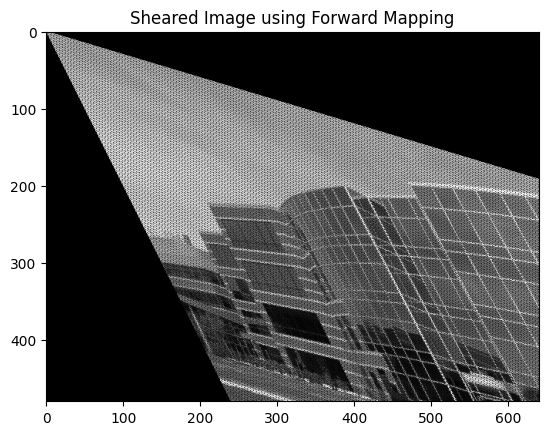

In [ ]:
# Shear transformation

# Define shear parameters
a = 0.5  # Shearing factor along the x-axis
b = 0.3  # Shearing factor along the y-axis

# Create the shear matrix
T_shear = np.array([[1, a],
                    [b, 1]])

# Create a new empty image of the size of the original
img_new = np.zeros(img.shape)

for y in range(img.shape[0]):  # Iterate each row
    for x in range(img.shape[1]):  # Iterate each column
        # Apply shear transformation
        pt = np.array([x, y])
        pt_new = T_shear @ pt
        x_new, y_new = np.rint(pt_new).astype(int)  # Round to nearest integer

        # Ensure the new coordinates are within bounds
        if 0 <= x_new < img.shape[1] and 0 <= y_new < img.shape[0]:
            img_new[y_new][x_new] = img[y][x]

# Display the transformed image
plt.imshow(img_new, cmap='gray')
plt.title('Sheared Image using Forward Mapping')
plt.show()

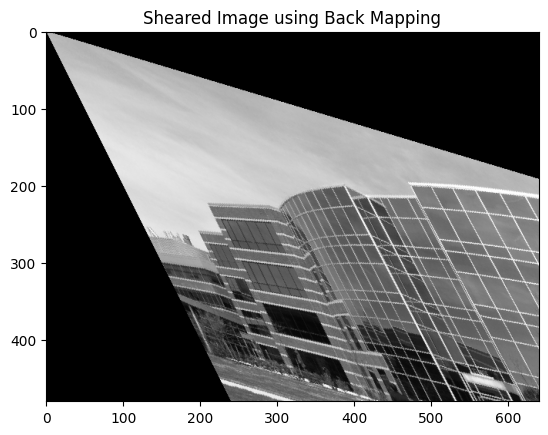

In [ ]:
# Shear transformation

# Parameters for shear
a = 0.5  # Shearing factor along the x-axis
b = 0.3  # Shearing factor along the y-axis

# Create the shear matrix
T_shear = np.array([[1, a],
                    [b, 1]])

# Inverse of the shear matrix
T_shear_inv = np.linalg.inv(T_shear)

# Create a new empty image of the size of the original
img_new = np.zeros(img.shape)

for y_new in range(img.shape[0]):  # Iterate each row in the output image
    for x_new in range(img.shape[1]):  # Iterate each column
        # Apply inverse transformation to get corresponding input pixel
        pt_new = np.array([x_new, y_new])
        pt = T_shear_inv @ pt_new
        x, y = np.rint(pt).astype(int)  # Nearest neighbor interpolation

        # Check that the resulting point is within the input image bounds
        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
            img_new[y_new][x_new] = img[y][x]

# Display the new image
plt.imshow(img_new, cmap='gray')
plt.title('Sheared Image using Back Mapping')
plt.show()

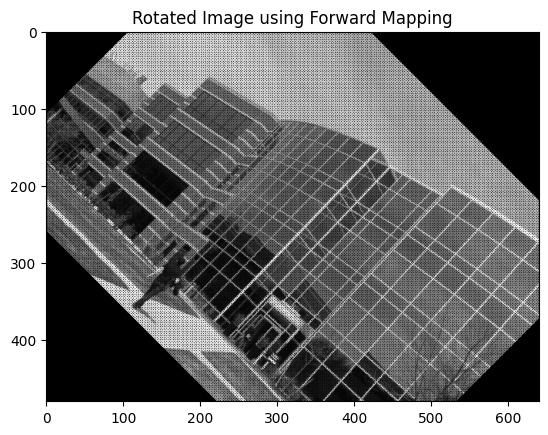

In [ ]:
# Rotation transformation

# Define rotation angle in degrees
theta = 45  # Example: Rotate by 45 degrees
theta_rad = np.radians(theta)  # Convert to radians

# Create the rotation matrix
T_rotation = np.array([[np.cos(theta_rad), -np.sin(theta_rad)],
                       [np.sin(theta_rad), np.cos(theta_rad)]])

# Create a new empty image of the size of the original
img_new = np.zeros(img.shape)

# Get the center of the image for rotation
center_x, center_y = img.shape[1] // 2, img.shape[0] // 2

for y in range(img.shape[0]):  # Iterate each row
    for x in range(img.shape[1]):  # Iterate each column
        # Translate to center, apply rotation, then translate back
        pt = np.array([x - center_x, y - center_y])
        pt_new = T_rotation @ pt
        x_new, y_new = np.rint(pt_new).astype(int)  # Round to nearest integer
        x_new, y_new = x_new + center_x, y_new + center_y  # Translate back

        # Ensure the new coordinates are within bounds
        if 0 <= x_new < img.shape[1] and 0 <= y_new < img.shape[0]:
            img_new[y_new][x_new] = img[y][x]

# Display the transformed image
plt.imshow(img_new, cmap='gray')
plt.title('Rotated Image using Forward Mapping')
plt.show()

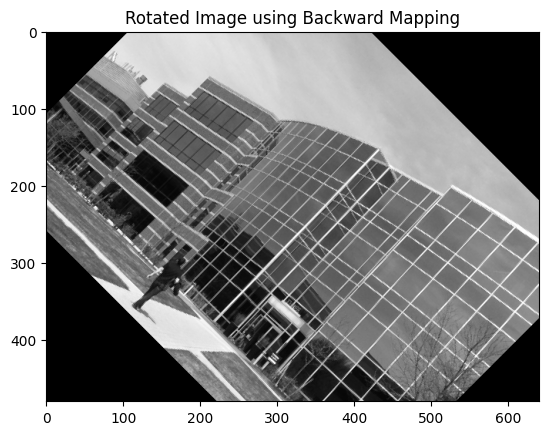

In [ ]:
# Define rotation angle in degrees
theta = 45  # Rotate by 45 degrees
theta_rad = np.radians(theta)  # Convert to radians

# Create the rotation matrix
T_rotation = np.array([[np.cos(theta_rad), -np.sin(theta_rad)],
                       [np.sin(theta_rad), np.cos(theta_rad)]])

# Compute the inverse transformation for backward mapping
T_inv = np.linalg.inv(T_rotation)

# Create a new empty image
img_new = np.zeros(img.shape)

# Get the center of the image for rotation
center_x, center_y = img.shape[1] // 2, img.shape[0] // 2

for y_new in range(img.shape[0]):  # Iterate each row in the output image
    for x_new in range(img.shape[1]):  # Iterate each column
        # Translate to center, apply inverse transformation, translate back
        pt_new = np.array([x_new - center_x, y_new - center_y])
        pt = T_inv @ pt_new  # Apply inverse transformation
        x, y = np.rint(pt).astype(int)  # Round to nearest integer
        x, y = x + center_x, y + center_y  # Translate back

        # Ensure the original pixel is within bounds
        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
            img_new[y_new, x_new] = img[y, x]

# Display the transformed image
plt.imshow(img_new, cmap='gray')
plt.title('Rotated Image using Backward Mapping')
plt.show()

<font color='blue'>

###### Question: why does the rotation "rotate" in a clockwise manner with positive angles?

Your answer here (double click to enter text)

In image processing, the coordinate system differs from the standard Cartesian plane. The origin is at the top-left corner, the x-axis extends to the right, and the y-axis extends downward. Because of this inverted y-axis, a transformation that would normally cause counterclockwise rotation in a traditional mathematical coordinate system appears as clockwise rotation in an image. This is a direct consequence of how pixel coordinates are defined in computer vision.

## Combining 2D transformations

The 2D transformations can be combined together, through matrix multiplication. Say we have two different transforms, $\textbf{T}_1$ and $\textbf{T}_2$. We have an image, that we wish to transform by $\textbf{T}_2$ first, and then $\textbf{T}_1$. Well, instead of doing two matrix multiplications on every point in the image, we can combine the transformations into a single matrix through matrix multiplication ($\textbf{T} = \textbf{T}_1\textbf{T}_2$, where $\textbf{T}$ is the overall matrix representation of the two transformations), and thus apply the two transforms using a single matrix multiplication.

<font color='blue'>
    
#### Task:

Combine the shear and rotation transformation by defining each matrix separately, and then multiplying them together.
    
In one code cell, apply it as $\textbf{T} = \textbf{T}_s\textbf{T}_r$
    
In another code cell, apply it as $\textbf{T} = \textbf{T}_r\textbf{T}_s$ (inverting the order of multiplication of the matrices)

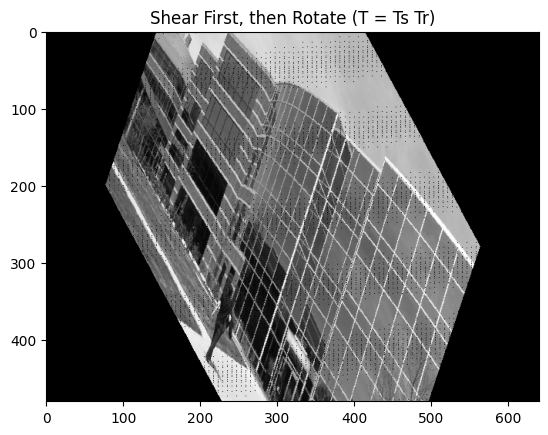

In [ ]:
# Define shear parameters
a, b = 0.5, 0.3  # Shear factors

# Define rotation angle (in degrees)
theta = 45
theta_rad = np.radians(theta)  # Convert to radians

# Define transformation matrices
T_shear = np.array([[1, a],
                    [b, 1]])

T_rotation = np.array([[np.cos(theta_rad), -np.sin(theta_rad)],
                       [np.sin(theta_rad), np.cos(theta_rad)]])

# Compute the combined transformation (Shear first, then Rotate)
T_combined = T_rotation @ T_shear

# Create a new empty image
img_new = np.zeros(img.shape)

# Get image center
center_x, center_y = img.shape[1] // 2, img.shape[0] // 2

for y in range(img.shape[0]):
    for x in range(img.shape[1]):
        # Translate to center, apply transformation, translate back
        pt = np.array([x - center_x, y - center_y])
        pt_new = T_combined @ pt
        x_new, y_new = np.rint(pt_new).astype(int)
        x_new, y_new = x_new + center_x, y_new + center_y

        # Ensure the new coordinates are within bounds
        if 0 <= x_new < img.shape[1] and 0 <= y_new < img.shape[0]:
            img_new[y_new][x_new] = img[y][x]

# Display the transformed image
plt.imshow(img_new, cmap='gray')
plt.title('Shear First, then Rotate (T = Ts Tr)')
plt.show()

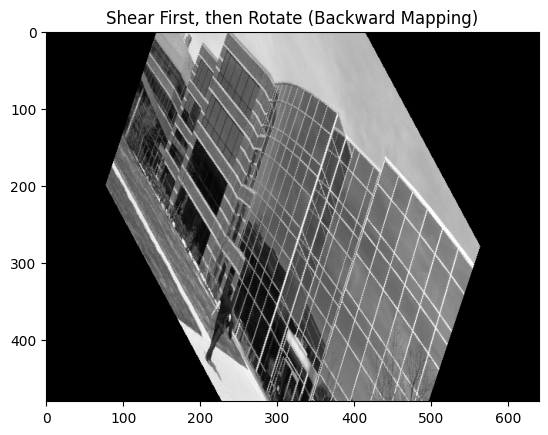

In [ ]:
# Define shear parameters
a, b = 0.5, 0.3  # Shear factors

# Define rotation angle (in degrees)
theta = 45
theta_rad = np.radians(theta)  # Convert to radians

# Define transformation matrices
T_shear = np.array([[1, a],
                    [b, 1]])

T_rotation = np.array([[np.cos(theta_rad), -np.sin(theta_rad)],
                       [np.sin(theta_rad), np.cos(theta_rad)]])

# Compute the combined transformation (Shear first, then Rotate)
T_combined = T_rotation @ T_shear

# Compute inverse transformation for backward mapping
T_inv = np.linalg.inv(T_combined)

# Create a new empty image
img_new = np.zeros(img.shape)

# Get image center
center_x, center_y = img.shape[1] // 2, img.shape[0] // 2

for y_new in range(img.shape[0]):
    for x_new in range(img.shape[1]):
        # Translate to center, apply inverse transformation, translate back
        pt_new = np.array([x_new - center_x, y_new - center_y])
        pt = T_inv @ pt_new
        x, y = np.rint(pt).astype(int)
        x, y = x + center_x, y + center_y

        # Ensure the original pixel is within bounds
        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
            img_new[y_new, x_new] = img[y, x]

# Display the transformed image
plt.imshow(img_new, cmap='gray')
plt.title('Shear First, then Rotate (Backward Mapping)')
plt.show()

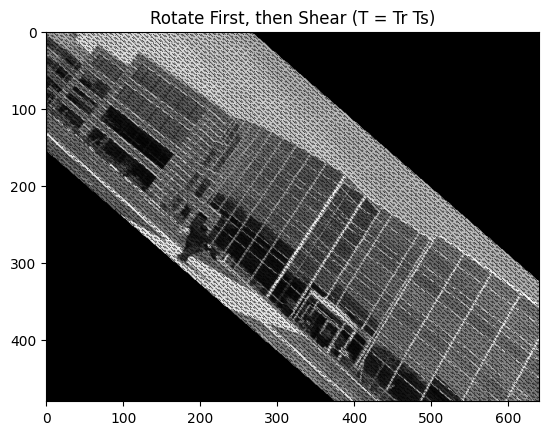

In [ ]:
# Compute the combined transformation (Rotate first, then Shear)
T_combined_2 = T_shear @ T_rotation

# Create a new empty image
img_new = np.zeros(img.shape)

for y in range(img.shape[0]):
    for x in range(img.shape[1]):
        # Translate to center, apply transformation, translate back
        pt = np.array([x - center_x, y - center_y])
        pt_new = T_combined_2 @ pt
        x_new, y_new = np.rint(pt_new).astype(int)
        x_new, y_new = x_new + center_x, y_new + center_y

        # Ensure the new coordinates are within bounds
        if 0 <= x_new < img.shape[1] and 0 <= y_new < img.shape[0]:
            img_new[y_new][x_new] = img[y][x]

# Display the transformed image
plt.imshow(img_new, cmap='gray')
plt.title('Rotate First, then Shear (T = Tr Ts)')
plt.show()

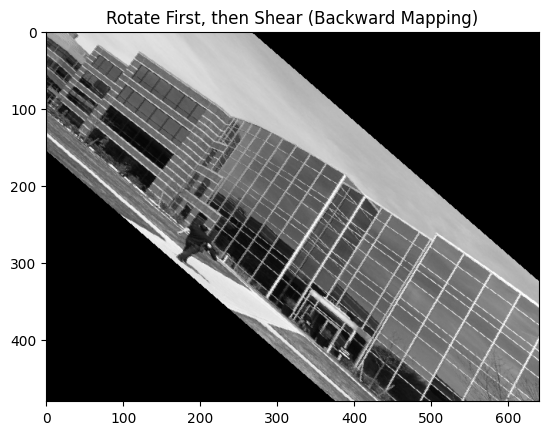

In [ ]:
# Compute the combined transformation (Rotate first, then Shear)
T_combined_2 = T_shear @ T_rotation

# Compute inverse transformation for backward mapping
T_inv_2 = np.linalg.inv(T_combined_2)

# Create a new empty image
img_new = np.zeros(img.shape)

for y_new in range(img.shape[0]):
    for x_new in range(img.shape[1]):
        # Translate to center, apply inverse transformation, translate back
        pt_new = np.array([x_new - center_x, y_new - center_y])
        pt = T_inv_2 @ pt_new
        x, y = np.rint(pt).astype(int)
        x, y = x + center_x, y + center_y

        # Ensure the original pixel is within bounds
        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
            img_new[y_new, x_new] = img[y, x]

# Display the transformed image
plt.imshow(img_new, cmap='gray')
plt.title('Rotate First, then Shear (Backward Mapping)')
plt.show()

<font color='blue'>

###### Question: When the two transforms are applied in different order, the result is different. Why is this?

Your answer here (double click to enter text)

The difference arises because matrix multiplication in 2D transformations is not commutative, meaning the order of operations matters. Each transformation modifies the coordinate system in which the next transformation operates.

When applying shear first, then rotation, the shear distorts the image along the axes, and the subsequent rotation acts on the sheared shape. Conversely, when applying rotation first, then shear, the rotation changes the orientation of the image before the shear is applied along the original coordinate axes.

Since these transformations are applied relative to the coordinate system at each step, swapping their order leads to different final results.

# Extra Credit

Some extra credit if you complete the following task. I will give you extra marks to compesnate for any failings in the other tasks in this e-tivity (if any).

<font color='blue'>
    
#### Task:

Take one of the transforms above, and do an implementation where you expland the size of the image to account for pixels that are outside the resulting image in the original implementation. You only need to account for the extra pixels in the positive axis dimensions. That is, if a pixel is transformed to a point with negative dimension values, you can still ignore this.
    
**Hint**: You can figure out the resulting image dimensions by forward transforming the four corners of the image.

transformed_corners:  [[  0.  958.5   0.  958.5]
 [  0.    0.  718.5 718.5]]


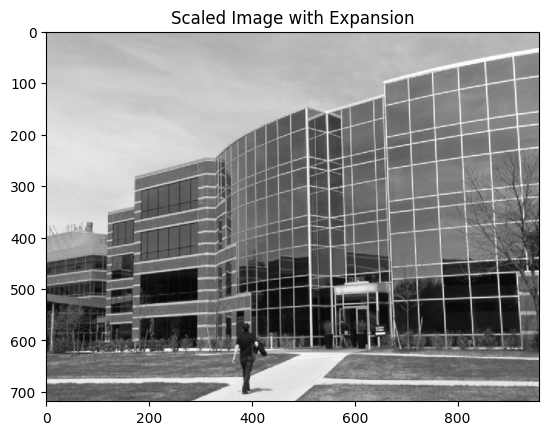

In [ ]:
def scale_and_expand_image(img, scale_x, scale_y):
    """
    Applies a scaling transformation to an image while expanding the output size
    to accommodate pixels that move beyond the original dimensions in the positive directions.

    Parameters:
        img (numpy array): The input grayscale image.
        scale_x (float): Scaling factor in the x direction.
        scale_y (float): Scaling factor in the y direction.

    Returns:
        img_new (numpy array): The transformed image with expanded dimensions.
    """

    # Get the original image dimensions
    h, w = img.shape

    # Define the scaling transformation matrix
    T = np.array([[scale_x, 0], [0, scale_y]])

    # Define the four corners of the original image
    corners = np.array([[0, 0], [w-1, 0], [0, h-1], [w-1, h-1]]).T  # Shape (2,4)

    # Apply the forward transformation to find new image bounds
    transformed_corners = T @ corners  # Shape (2,4)

    print('transformed_corners: ', transformed_corners)

    # Determine new image size (only considering positive expansion)
    new_w = int(np.ceil(np.max(transformed_corners[0])))
    new_h = int(np.ceil(np.max(transformed_corners[1])))

    # Create the expanded image
    img_new = np.zeros((new_h, new_w))

    # Compute inverse transformation for backward mapping
    T_inv = np.linalg.inv(T)

    # Apply backward mapping
    for y_new in range(new_h):
        for x_new in range(new_w):
            # Apply inverse transformation to get corresponding input pixel
            pt_new = np.array([x_new, y_new])
            pt = T_inv @ pt_new
            x, y = np.rint(pt).astype(int)

            # Check if the mapped pixel falls within the original image bounds.
            if 0 <= x < w and 0 <= y < h:
                img_new[y_new, x_new] = img[y, x]

    return img_new

# Example usage:
scale_x, scale_y = 1.5, 1.5  # Scaling factors

# Apply the scaling transformation with expansion
img_scaled = scale_and_expand_image(img, scale_x, scale_y)

# Display the transformed image
plt.imshow(img_scaled, cmap='gray')
plt.title('Scaled Image with Expansion')
plt.show()